# Inverse Noise Weighting

Say you have **M measurements** with some noise and **N parameters** that you need to fit for.

$$ g_i g_j^* V_{ij}^M = V_{ij} + n_{ij} = V_{ij}' $$
$$ g_l g_m^* V_{ij}^M = V_{lm} + n_{lm} = V_{lm}' $$ ...

The system of equations can be represented by the matrix equation:
$$ AX = Y $$

where A is the matrix of coefficients, X is the matrix of parameters ($g_i$, $g_j$, ... $V_{ij}$... ) and Y is matrix of measurement results which are noisy (with unknown noise properties in general).

The solution of the system of linear equations is given by:
$$ X = (A^{\dagger}N^{-1}A)^{-1}A^{\dagger}N^{-1}Y$$


$$N = nn^{\dagger}$$

## Noise matrix?

Some ways to understand the noise matrix:

$$N = \langle nn^{\dagger} \rangle$$ 

1. Is a diagonal matrix if there is no covariance.
2. Is proportional to the identity matrix if all measurements have the same noise. $N = nI$

In [55]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### Fit for a straight line

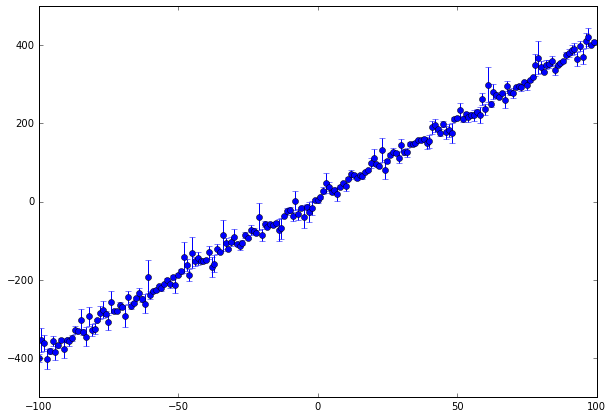

In [3]:
# Generate data

datapoints = 200

x = np.linspace(-100,99,num=datapoints)
n = np.random.normal(scale=15,size=datapoints)
y = 4*x + 10 + n

fig,ax = plt.subplots(1,1,figsize=(10,7))
ax.errorbar(x,y,yerr=n,fmt='o')
plt.show()

In [4]:
n = np.transpose(np.matrix(n))
N = np.dot(n,np.transpose(np.conj(n)))
print N.shape

(200, 200)


In [5]:
N

matrix([[  1.16271095e+02,  -3.38467640e+02,  -2.21528364e+02, ...,
          -2.53460613e+02,   5.30901401e+00,  -3.61858400e+01],
        [ -3.38467640e+02,   9.85286533e+02,   6.44873801e+02, ...,
           7.37829260e+02,  -1.54546532e+01,   1.05337753e+02],
        [ -2.21528364e+02,   6.44873801e+02,   4.22072367e+02, ...,
           4.82912071e+02,  -1.01151296e+01,   6.89439622e+01],
        ..., 
        [ -2.53460613e+02,   7.37829260e+02,   4.82912071e+02, ...,
           5.52521525e+02,  -1.15731769e+01,   7.88819029e+01],
        [  5.30901401e+00,  -1.54546532e+01,  -1.01151296e+01, ...,
          -1.15731769e+01,   2.42413042e-01,  -1.65226905e+00],
        [ -3.61858400e+01,   1.05337753e+02,   6.89439622e+01, ...,
           7.88819029e+01,  -1.65226905e+00,   1.12617415e+01]])

### Doubts:

I don't understand the noise matrix. How can it be diagonal if it is not time averaged? What does time averaging mean for a given experiment?

N = nI in the experiment below -- same noise (not statistically same, exactly same?) for all measurements.

In [6]:
# Generating N as some noise times the identity matrix
N = 225*np.identity(datapoints)

In [7]:
Ninv = np.linalg.inv(N)
A = np.transpose(np.matrix([x,y]))
Y = 10*np.transpose(np.matrix(np.ones(datapoints)))
print Ninv.shape, A.shape, Y.shape

(200, 200) (200, 2) (200, 1)


In [8]:
A

matrix([[-100.        , -400.78290752],
        [ -99.        , -354.61072583],
        [ -98.        , -361.45560009],
        [ -97.        , -403.08182479],
        [ -96.        , -382.43937509],
        [ -95.        , -357.51555682],
        [ -94.        , -386.2487987 ],
        [ -93.        , -368.24369808],
        [ -92.        , -353.57134577],
        [ -91.        , -377.00814544],
        [ -90.        , -354.56222529],
        [ -89.        , -358.14292095],
        [ -88.        , -349.37143123],
        [ -87.        , -328.79478074],
        [ -86.        , -332.7702699 ],
        [ -85.        , -302.2827571 ],
        [ -84.        , -333.36930837],
        [ -83.        , -345.80596964],
        [ -82.        , -293.63617873],
        [ -81.        , -329.72923061],
        [ -80.        , -325.14797927],
        [ -79.        , -302.80511274],
        [ -78.        , -284.58130359],
        [ -77.        , -276.86583777],
        [ -76.        , -287.17348437],


In [9]:
# Since A is real, dagger is just transpose.

x1 = np.linalg.inv(np.dot(A.T,np.dot(Ninv,A)))
x2 = np.dot(A.T,np.dot(Ninv,Y))

X = np.dot(x1,x2)

In [10]:
X

matrix([[-1.26419119],
        [ 0.31528324]])

In [11]:
A = np.matrix([[2,3],[4,6]])

In [12]:
# Define matrix M as params averaged over all measurements
M = np.dot(A.T,A)
print M

[[20 30]
 [30 45]]


In [15]:
np.linalg.inv(M)

matrix([[ -9.00719925e+14,   6.00479950e+14],
        [  6.00479950e+14,  -4.00319967e+14]])

In [13]:
U,s,V = np.linalg.svd(M)

In [14]:
print U, s, V

[[-0.5547002  -0.83205029]
 [-0.83205029  0.5547002 ]] [  6.50000000e+01   2.96970477e-15] [[-0.5547002  -0.83205029]
 [-0.83205029  0.5547002 ]]


# Eigen Spectrum

The Eigen spectrum shows how well constrained the parameters are. Higher the eigen value, lower the noise on that parameter. Degenerate parameters have an eigen value of zero, implying that they cannot be constained at all.

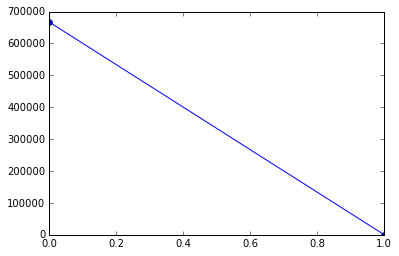

In [11]:
plt.plot(np.arange(2),s,'o-')
plt.show()

In [14]:
np.round(U,decimals=2)

array([[-1.,  0.],
       [ 0.,  1.]])

In [15]:
np.round(M,decimals=2)

array([[  6.66700000e+05,  -1.00000000e+02],
       [ -1.00000000e+02,   2.00000000e+02]])

In [16]:
s

array([  6.66700015e+05,   1.99984996e+02])

### Generate matrix A for the HERA antenna layout

In [26]:
import hera_cal

Nants = 37

ants = np.loadtxt('antenna_positions_%d.dat'%Nants)
idxs = np.arange(Nants)
antpos = {}
for k,v in zip(idxs,ants):
    antpos[k] = v
    
redbls = hera_cal.redcal.get_pos_reds(antpos)

In [27]:
def genA(redbls):
    # number of measurements = total number of baselines
    M = 0
    for i in range(len(redbls)):
        M += len(redbls[i])
    
    # number of parameters = num_ants + num_unique baselines
    N = Nants + len(redbls)
    
    A = np.zeros([M,N],dtype=np.complex)
    i = 0
    for bl,reds in enumerate(redbls):
        for pair in reds:
            A[i,pair[0]] = 1+1j
            A[i,pair[1]] = 1-1j
            A[i,Nants+bl] = 1+1j
            i += 1
    return np.matrix(A)

In [28]:
A = genA(redbls)

In [30]:
print A.shape, Nants+len(redbls)

(666, 100) 100


In [31]:
np.real(A)

matrix([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  1., ...,  0.,  0.,  0.],
        ..., 
        [ 1.,  0.,  0., ...,  1.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [34]:
np.real(A[0])

matrix([[ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [47]:
np.where(A[1]!=0)

(array([0, 0, 0]), array([  1,   9, 128]))

In [35]:
M = np.dot(np.real(A).T,np.real(A))

In [37]:
print M.shape, M[0]

(100, 100) [[ 36.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
    1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
    1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.   1.
    1.   1.   1.   1.   0.   1.   0.   1.   1.   1.   1.   1.   1.   0.
    1.   1.   1.   0.   1.   1.   1.   0.   0.   1.   0.   0.   1.   1.
    1.   1.   0.   0.   0.   0.   1.   0.   1.   0.   1.   0.   1.   1.
    0.   1.   0.   0.   0.   0.   1.   1.   0.   1.   0.   0.   0.   1.
    0.   0.]]


In [38]:
U,S,V = np.linalg.svd(M)

In [39]:
S

array([  8.97654178e+01,   3.83550245e+01,   3.83362128e+01,
         3.83362128e+01,   3.61401994e+01,   3.61112054e+01,
         3.61112054e+01,   3.59117451e+01,   3.59117451e+01,
         3.55801823e+01,   3.55386885e+01,   3.55386885e+01,
         3.53169577e+01,   3.52692027e+01,   3.52692027e+01,
         3.52113668e+01,   3.51328270e+01,   3.51328270e+01,
         3.50542788e+01,   3.50000000e+01,   3.50000000e+01,
         3.50000000e+01,   3.50000000e+01,   3.50000000e+01,
         3.50000000e+01,   3.50000000e+01,   3.50000000e+01,
         3.50000000e+01,   3.50000000e+01,   3.50000000e+01,
         3.50000000e+01,   3.50000000e+01,   3.50000000e+01,
         3.50000000e+01,   3.50000000e+01,   3.50000000e+01,
         3.50000000e+01,   2.94603000e+01,   2.94603000e+01,
         2.76151373e+01,   2.35456935e+01,   2.35456935e+01,
         2.32218409e+01,   2.28182382e+01,   2.28182382e+01,
         2.01871741e+01,   1.79011026e+01,   1.79011026e+01,
         1.78864283e+01,

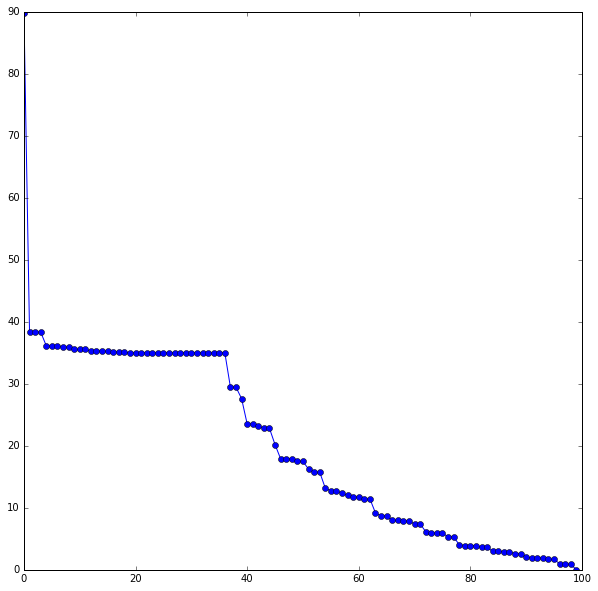

In [56]:
plt.figure(figsize=(10,10))
plt.plot(S,'o-')
plt.show()

In [44]:
U[:,-1]

matrix([[ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [ 0.05882353],
        [-0.11764706],
        [-0.11764706],
        [-0.11764706],
        [-0.11764706],
        [-0.11764706],
        [-0.11764706],
        [-0

In [45]:
U[:,0]

matrix([[ 0.13499132],
        [ 0.13992692],
        [ 0.13992692],
        [ 0.13499132],
        [ 0.13992692],
        [ 0.14869663],
        [ 0.1516153 ],
        [ 0.14869663],
        [ 0.13992692],
        [ 0.13992692],
        [ 0.1516153 ],
        [ 0.15794249],
        [ 0.15794249],
        [ 0.1516153 ],
        [ 0.13992692],
        [ 0.13499132],
        [ 0.14869663],
        [ 0.15794249],
        [ 0.16117712],
        [ 0.15794249],
        [ 0.14869663],
        [ 0.13499132],
        [ 0.13992692],
        [ 0.1516153 ],
        [ 0.15794249],
        [ 0.15794249],
        [ 0.1516153 ],
        [ 0.13992692],
        [ 0.13992692],
        [ 0.14869663],
        [ 0.1516153 ],
        [ 0.14869663],
        [ 0.13992692],
        [ 0.13499132],
        [ 0.13992692],
        [ 0.13992692],
        [ 0.13499132],
        [ 0.1484167 ],
        [ 0.1484167 ],
        [ 0.1484167 ],
        [ 0.10860538],
        [ 0.10860538],
        [ 0.10860538],
        [ 0

In [57]:
U[:,1]

matrix([[ 0.21397922],
        [ 0.12865952],
        [ 0.12865952],
        [ 0.21397922],
        [ 0.12865952],
        [ 0.00426969],
        [-0.07052632],
        [ 0.00426969],
        [ 0.12865952],
        [ 0.12865952],
        [-0.07052632],
        [-0.2192312 ],
        [-0.2192312 ],
        [-0.07052632],
        [ 0.12865952],
        [ 0.21397922],
        [ 0.00426969],
        [-0.2192312 ],
        [-0.30571807],
        [-0.2192312 ],
        [ 0.00426969],
        [ 0.21397922],
        [ 0.12865952],
        [-0.07052632],
        [-0.2192312 ],
        [-0.2192312 ],
        [-0.07052632],
        [ 0.12865952],
        [ 0.12865952],
        [ 0.00426969],
        [-0.07052632],
        [ 0.00426969],
        [ 0.12865952],
        [ 0.21397922],
        [ 0.12865952],
        [ 0.12865952],
        [ 0.21397922],
        [-0.08316703],
        [-0.08316703],
        [-0.08316703],
        [-0.10543244],
        [-0.10543244],
        [-0.10543244],
        [-0